## Mengunduh Dataset yang ada di Google Drive

In [1]:
# Mengimpor modul drive dari google.colab untuk mengakses Google Drive
from google.colab import drive

# Memasang (mount) Google Drive ke direktori /content/drive sehingga file-file di Google Drive dapat diakses
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Menginstal gdown untuk mengunduh file dari Google Drive
!pip install gdown

In [3]:
#Mengunduh File dataset
import gdown

file_id = '143GL3002-oplVletQwKsYEgRuHWS53tn'
output = '/content/dataset.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=143GL3002-oplVletQwKsYEgRuHWS53tn
From (redirected): https://drive.google.com/uc?id=143GL3002-oplVletQwKsYEgRuHWS53tn&confirm=t&uuid=f86ecf34-6b47-4f73-abab-32d71320f474
To: /content/dataset.zip
100%|██████████| 1.46G/1.46G [00:27<00:00, 53.7MB/s]


'/content/dataset.zip'

## Ekstrak Dataset

In [4]:
import zipfile
import os
from natsort import natsorted
from PIL import Image
import pandas as pd

# Path ke file zip dan direktori tujuan ekstraksi
zip_file_path = 'dataset.zip'
extract_dir = 'Dataset'

# Membuat direktori tujuan jika belum ada
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Mengekstrak file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Ekstraksi selesai.")

# Path direktori dataset yang telah diekstrak
train_dir = os.path.join(extract_dir, 'images', 'train')
val_dir = os.path.join(extract_dir, 'images', 'val')

# List semua subdirektori di train dan val
train_subdirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
val_subdirs = [d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))]

# Fungsi untuk merename file dalam direktori
def rename_files(dataset_dir):
    subdirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    for subdir in subdirs:
        subdir_path = os.path.join(dataset_dir, subdir)
        file_paths = []

        # List semua file dalam subdirektori
        for root, dirs, files in os.walk(subdir_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_paths.append(os.path.join(root, file))

        # Urutkan file secara alami
        file_paths = natsorted(file_paths)

        # Menentukan nomor awal untuk penamaan baru
        start_number = 1

        # Loop untuk merename setiap file dalam subdirektori
        for index, file_path in enumerate(file_paths, start=start_number):
            # Dapatkan direktori dan ekstensi file
            dir_name = os.path.dirname(file_path)
            ext = os.path.splitext(file_path)[1]

            # Buat nama file baru dengan format "Bisindo_<subdir>_<number>.ext"
            new_file_name = f"Bisindo_{subdir}_{index}{ext}"
            new_file_path = os.path.join(dir_name, new_file_name)

            # Rename file
            os.rename(file_path, new_file_path)
            print(f"Renamed '{file_path}' to '{new_file_path}'")

print("Renaming files in train directory...")
rename_files(train_dir)
print("Renaming files in val directory...")
rename_files(val_dir)
print("Renaming complete.")

Streaming output truncated to the last 5000 lines.
Renamed 'Dataset/images/train/R/flip051.jpg' to 'Dataset/images/train/R/Bisindo_R_128.jpg'
Renamed 'Dataset/images/train/R/flip052.jpg' to 'Dataset/images/train/R/Bisindo_R_129.jpg'
Renamed 'Dataset/images/train/R/flip053.jpg' to 'Dataset/images/train/R/Bisindo_R_130.jpg'
Renamed 'Dataset/images/train/R/flip054.jpg' to 'Dataset/images/train/R/Bisindo_R_131.jpg'
Renamed 'Dataset/images/train/R/flip055.jpg' to 'Dataset/images/train/R/Bisindo_R_132.jpg'
Renamed 'Dataset/images/train/R/flip057.jpg' to 'Dataset/images/train/R/Bisindo_R_133.jpg'
Renamed 'Dataset/images/train/R/flip059.jpg' to 'Dataset/images/train/R/Bisindo_R_134.jpg'
Renamed 'Dataset/images/train/R/flip061.jpg' to 'Dataset/images/train/R/Bisindo_R_135.jpg'
Renamed 'Dataset/images/train/R/flip064.jpg' to 'Dataset/images/train/R/Bisindo_R_136.jpg'
Renamed 'Dataset/images/train/R/flip065.jpg' to 'Dataset/images/train/R/Bisindo_R_137.jpg'
Renamed 'Dataset/images/train/R/flip066

In [6]:
print("Files in extracted path:")
print(os.listdir(extract_dir))


Files in extracted path:
['images']


## Import Library

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from google.colab import files
import io


import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

## Baca Dataset

In [8]:
import os
from PIL import Image
import pandas as pd

# Path Direktori Dataset
train_dir = 'Dataset/images/train'
val_dir = 'Dataset/images/val'
image_data = []

# Fungsi untuk memuat gambar ke dalam DataFrame
def load_images(root_dir, set_name):
    subdirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for subdir in subdirs:
        label = subdir  # Nama subdirektori sebagai label
        label_dir = os.path.join(root_dir, subdir)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image = Image.open(image_path)
                image_data.append({
                    'label': label,
                    'set': set_name,
                    'color_image': image
                })

# Memuat gambar dari direktori train dan val
load_images(train_dir, 'train')
load_images(val_dir, 'val')

# Membuat DataFrame
df = pd.DataFrame(image_data)

print("Train and Validation DataFrame:")
print(df.head())


Train and Validation DataFrame:
  label    set                                        color_image
0     G  train  <PIL.JpegImagePlugin.JpegImageFile image mode=...
1     G  train  <PIL.JpegImagePlugin.JpegImageFile image mode=...
2     G  train  <PIL.JpegImagePlugin.JpegImageFile image mode=...
3     G  train  <PIL.JpegImagePlugin.JpegImageFile image mode=...
4     G  train  <PIL.JpegImagePlugin.JpegImageFile image mode=...


In [9]:
df

,label,set,color_image
0,G,train,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,G,train,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,G,train,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,G,train,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,G,train,<PIL.JpegImagePlugin.JpegImageFile image mode=...
...,...,...,...
11465,H,val,<PIL.JpegImagePlugin.JpegImageFile image mode=...
11466,H,val,<PIL.JpegImagePlugin.JpegImageFile image mode=...
11467,H,val,<PIL.JpegImagePlugin.JpegImageFile image mode=...
11468,H,val,<PIL.JpegImagePlugin.JpegImageFile image mode=...


## Visualisasi Distribusi dan Contoh Gambar dari Dataset

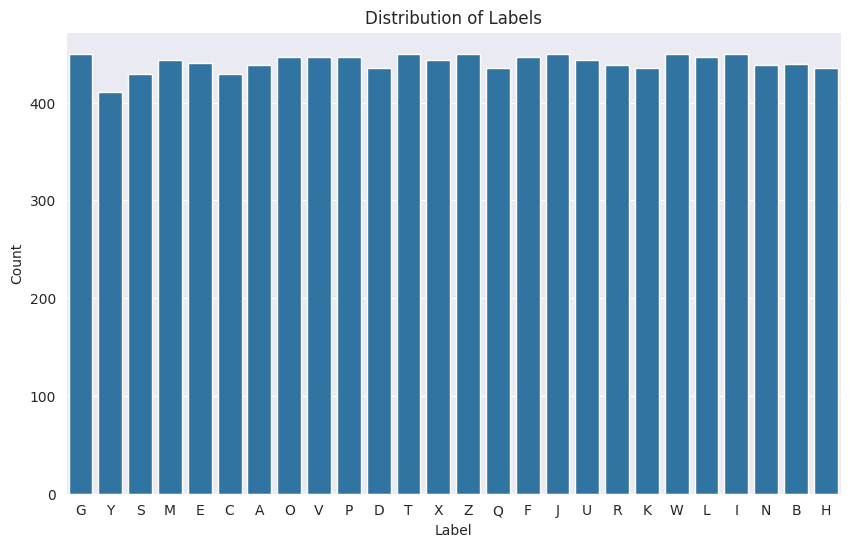

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribusi label dalam dataset
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.countplot(data=df, x='label')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

plt.show()


In [11]:
import matplotlib.pyplot as plt

# Mengatur ukuran subplots
fig, axs = plt.subplots(5, 6, figsize=(18, 15))  # Mengatur subplot menjadi 5 baris dan 6 kolom

# Mendapatkan satu contoh gambar untuk setiap label
example_images = df.groupby('label').first().reset_index()[['label', 'color_image']]

# Loop untuk menampilkan contoh gambar
for i, (label, image) in enumerate(example_images.itertuples(index=False)):
    ax = axs[i // 6, i % 6]  # Sesuaikan dengan layout 5x6
    ax.imshow(image)
    ax.set_title('Label {}'.format(label))
    ax.axis('off')

# Menyembunyikan sumbu kosong jika ada
for j in range(i + 1, 5 * 6):
    fig.delaxes(axs[j // 6, j % 6])

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Membagi Dataset untuk Melatih Model

In [12]:
# Mengonversi label dari string ke integer
def get_label_to_int_mapping(directory):
    subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    return {label: idx for idx, label in enumerate(sorted(subdirs))}

label_to_int = get_label_to_int_mapping(train_dir)
int_to_label = {v: k for k, v in label_to_int.items()}
num_classes = len(label_to_int)

# Fungsi untuk memproses gambar dan label
def process_image(image_path, label):
    image = Image.open(image_path)
    resized_image = image.resize((32, 32))
    return np.array(resized_image) / 255.0, label_to_int[label]

# Membuat generator data untuk dataset
def create_generator(directory, batch_size):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical',
        classes=sorted(label_to_int.keys())
    )
    return generator

# Mengatur batch size
batch_size = 32

# Membuat generator untuk training dan validation
train_generator = create_generator(train_dir, batch_size)
val_generator = create_generator(val_dir, batch_size)

# Melihat contoh penggunaan generator
for batch in train_generator:
    X_batch, y_batch = batch
    print(f'X_batch shape: {X_batch.shape}')
    print(f'y_batch shape: {y_batch.shape}')
    break


Found 9169 images belonging to 26 classes.
Found 2301 images belonging to 26 classes.
X_batch shape: (32, 32, 32, 3)
y_batch shape: (32, 26)


## Buat Model

In [13]:
# Membangun model
model = Sequential([
    Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    Conv2D(50, (3, 3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    Conv2D(25, (3, 3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Perhatikan perubahan di sini
])

# Mengkompilasi model
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

# Merangkum model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 75)        2100      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 16, 16, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 50)        2

## Melatih Model

In [18]:
# Callback untuk mengurangi learning rate
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.0001
)

# Melatih model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction]
)

Epoch 1/30
287/287 [==============================] - 90s 299ms/step - loss: 2.1092 - accuracy: 0.4650 - val_loss: 2.7573 - val_accuracy: 0.1838 - lr: 0.0100
Epoch 2/30
287/287 [==============================] - 97s 338ms/step - loss: 1.0903 - accuracy: 0.7212 - val_loss: 1.0710 - val_accuracy: 0.7592 - lr: 0.0100
Epoch 3/30
287/287 [==============================] - 85s 298ms/step - loss: 0.8607 - accuracy: 0.7718 - val_loss: 0.7891 - val_accuracy: 0.7966 - lr: 0.0100
Epoch 4/30
287/287 [==============================] - 85s 297ms/step - loss: 0.7170 - accuracy: 0.7982 - val_loss: 0.7564 - val_accuracy: 0.7914 - lr: 0.0100
Epoch 5/30
287/287 [==============================] - 95s 330ms/step - loss: 0.6210 - accuracy: 0.8223 - val_loss: 0.6481 - val_accuracy: 0.8231 - lr: 0.0100
Epoch 6/30
287/287 [==============================] - 84s 293ms/step - loss: 0.5575 - accuracy: 0.8405 - val_loss: 1.0226 - val_accuracy: 0.7032 - lr: 0.0100
Epoch 7/30
287/287 [==============================] 

## Visualisasi Metrik dan Confusion Matrix

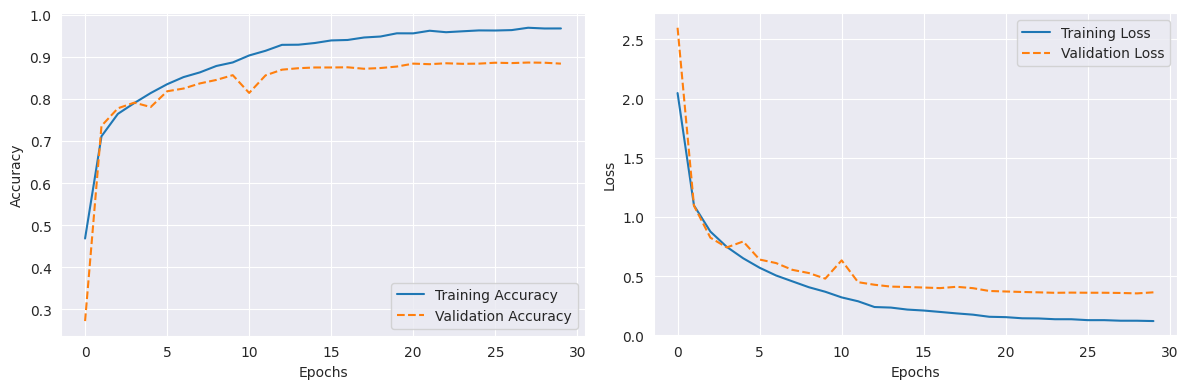

In [ ]:
import matplotlib.pyplot as plt

# Membuat subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Mendefinisikan label plot dan gaya
plot_labels = ['Accuracy', 'Loss']
plot_styles = ['-', '--']

# Plot akurasi dan loss pelatihan dan pengujian
for i, metric in enumerate(['accuracy', 'loss']):
    train_metric = history.history[metric]
    val_metric = history.history['val_' + metric]
    axs[i].plot(train_metric, label='Training ' + metric.capitalize(), linestyle=plot_styles[0])
    axs[i].plot(val_metric, label='Validation ' + metric.capitalize(), linestyle=plot_styles[1])
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel(plot_labels[i])
    axs[i].legend()

# Menyesuaikan layout dan menampilkan plot
plt.tight_layout()
plt.show()


In [ ]:
# Mendapatkan prediksi model pada set pengujian
y_pred = model.predict(X_batch)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_batch, axis=1)

# Menampilkan beberapa hasil prediksi
print(f"Prediksi: {y_pred_classes[:26]}")
print(f"Label Sebenarnya: {y_true_classes[:26]}")


1/1 [==============================] - 0s 47ms/step
Prediksi: [11  5  4 23  8  5  4 14 18 25 24  8  5 17  4 16 17 16  8 25 20  1  2 16
 24 15]
Label Sebenarnya: [11  5  4 23  8  5  4 14 18 25 24  8  5 11  4 16 17 16  8 25 20  1  2 16
 24 15]


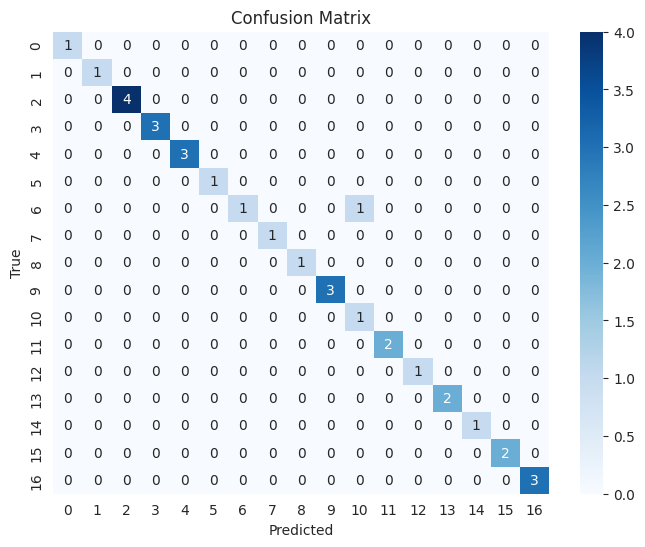

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Membuat confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Mengevaluasi model pada set pengujian
accuracy = model.evaluate(X_batch, y_batch)
print(f'validation test results - Loss: {accuracy[0]} - Accuracy: {accuracy[1]*100}%')

1/1 [==============================] - 0s 67ms/step - loss: 0.0709 - accuracy: 0.9688
validation test results - Loss: 0.07088831067085266 - Accuracy: 96.875%


In [ ]:
# Definisi path untuk menyimpan model
MODEL_BASE_PATH = "ModelBisindo"
PROJECT_NAME = "Capstone"
SAVE_MODEL_NAME = "Bisindo_" + datetime.now().strftime("%d_%m_%Y") + ".h5"  # Format nama file sesuai tanggal
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

# Buat direktori proyek jika belum ada
if not os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)):
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

# Simpan model
print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path, include_optimizer=False)

print(f"Model berhasil disimpan dengan nama '{SAVE_MODEL_NAME}' di direktori '{os.path.join(MODEL_BASE_PATH, PROJECT_NAME)}'")


Saving Model At ModelBisindo/Capstone/Bisindo_18_06_2024.h5...
Model berhasil disimpan dengan nama 'Bisindo_18_06_2024.h5' di direktori 'ModelBisindo/Capstone'


In [ ]:
# Memuat model yang telah disimpan
SAVE_MODEL_NAME = "/content/ModelBisindo/Capstone/Bisindo_18_06_2024.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

loaded_model = load_model(save_model_path)
loaded_model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

# Fungsi untuk menyiapkan gambar
def prepare_image(image):
    image = image.convert("RGB") if image.mode != "RGB" else image
    image = image.resize((32, 32))
    image = np.array(image) / 255.0
    return np.expand_dims(image, axis=0)

# Fungsi untuk melakukan prediksi pada gambar
def predict_image(image, model):
    processed_image = prepare_image(image)
    prediction = model.predict(processed_image)
    pred_class = np.argmax(prediction, axis=1)[0]
    predicted_confidence = np.max(prediction)
    return pred_class, predicted_confidence

# Mengunggah dan memprediksi gambar
uploaded = files.upload()

for filename in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[filename]))
    pred_class, confidence = predict_image(image, loaded_model)
    print(f'Predicted class: {pred_class}, Confidence: {confidence:.2f}')

Saving WhatsApp Image 2024-06-11 at 18.23.04 (2).jpeg to WhatsApp Image 2024-06-11 at 18.23.04 (2).jpeg


1/1 [==============================] - 0s 202ms/step
Predicted class: 0, Confidence: 0.64


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 22ms/step


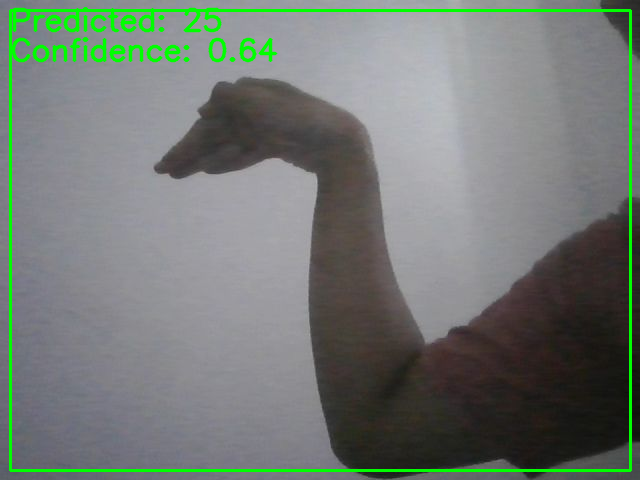

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def prepare_image(image):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize((32, 32))
    image = np.array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Ambil gambar menggunakan webcam
image_file = take_photo()
image = cv2.imread(image_file)

# Ubah ukuran gambar agar sesuai dengan model
image_resized = cv2.resize(image, (32, 32))
image_pil = Image.fromarray(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
processed_image = prepare_image(image_pil)

# Prediksi dengan model
prediction = loaded_model.predict(processed_image)
pred_class = np.argmax(prediction, axis=1)[0]
predicted_confidence = np.max(prediction)

# Tambahkan bingkai hijau dan teks prediksi pada gambar
color = (0, 255, 0)  # Warna hijau dalam BGR
thickness = 2
cv2.rectangle(image, (10, 10), (image.shape[1] - 10, image.shape[0] - 10), color, thickness)
cv2.putText(image, f"Predicted: {pred_class}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
cv2.putText(image, f"Confidence: {predicted_confidence:.2f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

# Tampilkan gambar
cv2_imshow(image)